Run on NERSC

In [8]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

import match_coord

In [9]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [10]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [11]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

vranges = {'g':0.08, 'r':0.012, 'z':0.03}

In [12]:
image_dir = '/global/project/projectdirs/cosmo/staging/'

ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'

ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

# plt.figure(figsize=(10, 5))
# plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
# plt.show()

# gaia = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_sample_for_ccd_cutouts-decals_ngc.fits')

0.560138739773


In [13]:
ra, dec = 148.12184029623234, 31.54267097002469
gaia_g, gaia_bp, gaia_rp = 7.46, 7.96, 6.84
print(gaia_bp-gaia_rp)

1.12


In [14]:
# Gaia-to-DECam transformations used in legacypipe
ls_mag = {}
color = gaia_bp - gaia_rp
bands = ['g', 'r', 'z']
for i,b in enumerate(bands):
    # Use Arjun's Gaia-to-DECam transformations.
    coeffs = dict(
        g=[-0.11368, 0.37504, 0.17344, -0.08107, 0.28088,
           -0.21250, 0.05773,-0.00525],
        r=[ 0.10533,-0.22975, 0.06257,-0.24142, 0.24441,
            -0.07248, 0.00676],
        z=[ 0.46744,-0.95143, 0.19729,-0.08810, 0.01566])[b]
    mag = gaia_g
    for order,c in enumerate(coeffs):
        mag += c * color**order
    ls_mag[b] = mag
print(ls_mag)

{'g': 8.039845639423591, 'r': 7.317512473171108, 'z': 7.0101861323776005}


In [15]:
# maximum RA, Dec separation for DECam CCDs
max_d_ra, max_d_dec = 4096*0.262/2, 2046*0.262/2
max_d_ra, max_d_dec = max_d_ra*0.95, max_d_dec*0.95 # trim CCD edges

idx1, idx2, d2d, d_ra, d_dec = match_coord.search_around([ra], [dec], ccd['ra'], ccd['dec'], search_radius=max(max_d_ra, max_d_dec))

mask = np.abs(d_ra)<max_d_ra
mask &= np.abs(d_dec)<max_d_dec
print(np.sum(mask))
# mask &= ccd['filter'][idx2]==band
# print(np.sum(mask))
idx1 = idx1[mask]
idx2 = idx2[mask]

ccd0 = ccd[idx2]
print(len(ccd0), 'CCD images available')

16 nearby objects
10
10 CCD images available


In [27]:
band = 'g'

# vrange = vranges[band]
vrange = 0.03

mask = ccd0['filter']==band
ccd1 = ccd0[mask]

expnum_halo = 535126
ccd1_index = np.where(ccd1['expnum']==expnum_halo)[0][0]
print(ccd1_index)

2


__Get blob mask__

4


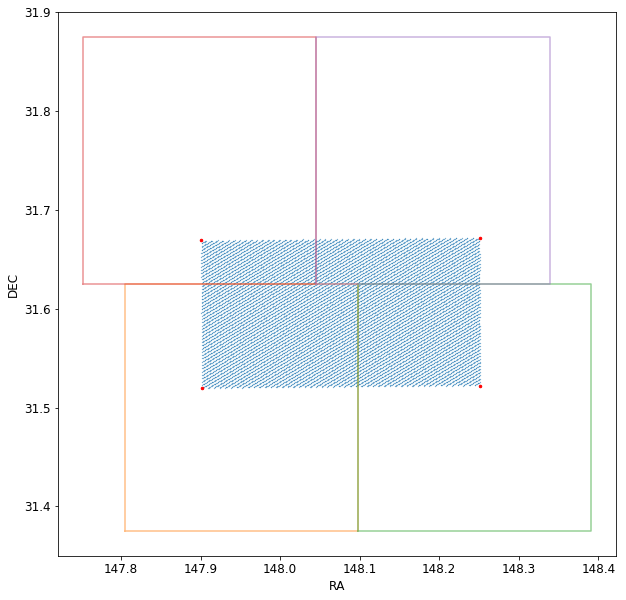

-1
1665
-1
-1


In [49]:
# Load brick list
bricks = Table.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-bricks.fits.gz')

img_fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index]).strip()
hdulist = fits.open(img_fn)
w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
naxis1 = hdulist[ccd1['image_hdu'][ccd1_index]].header['NAXIS1']
naxis2 = hdulist[ccd1['image_hdu'][ccd1_index]].header['NAXIS2']

# here x and y are not numpy indices, but they are the x-y values in the DECam CCD schematics
pix_x_grid, pix_y_grid = np.meshgrid(np.arange(naxis1), np.arange(naxis2))
pix_x, pix_y = pix_x_grid.flatten(), pix_y_grid.flatten()
pix_ra, pix_dec = w.wcs_pix2world(pix_x, pix_y, 0)
# I have checked and confired that this CCD offset correction does lead to better alignment 
# with the coadds than without the correction
pix_ra = pix_ra + ccd1['ccdraoff'][ccd1_index] / 3600.
pix_dec = pix_dec + ccd1['ccddecoff'][ccd1_index] / 3600.

# Find bricks that cover the CCD
ccd_corners = [[pix_ra.min(), pix_dec.min()], 
               [pix_ra.min(), pix_dec.max()], 
               [pix_ra.max(), pix_dec.min()], 
               [pix_ra.max(), pix_dec.max()]]
ccd_corners = np.array(ccd_corners)
mask = np.zeros(len(bricks), dtype=bool)
for index in range(len(ccd_corners)):
    mask |= (bricks['RA1']<ccd_corners[index, 0]) & (bricks['RA2']>ccd_corners[index, 0]) \
     & (bricks['DEC1']<ccd_corners[index, 1]) & (bricks['DEC2']>ccd_corners[index, 1])
print(np.sum(mask))
brick_idx = np.where(mask)[0]

# Diagnostic plot to check the brick coverage
points = w.wcs_pix2world([[0,0], [naxis1, naxis2], [0, naxis2], [naxis1, 0]], 0)
plt.figure(figsize=(10, 10))
plt.plot(pix_ra[::500], pix_dec[::500], '.', ms=0.5)
for index in brick_idx:
    ra_plot = [bricks['RA1'][index], bricks['RA1'][index], bricks['RA2'][index], bricks['RA2'][index], bricks['RA1'][index]]
    dec_plot = [bricks['DEC1'][index], bricks['DEC2'][index], bricks['DEC2'][index], bricks['DEC1'][index], bricks['DEC1'][index]]
    plt.plot(ra_plot, dec_plot, alpha=0.5)
plt.plot(points[:, 0], points[:, 1], '.', ms=5, color='r')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

# Obtain the blob mask
img_mask = np.zeros([naxis2, naxis1], dtype=bool)
for brick_index in brick_idx:
    brickname = bricks['BRICKNAME'][brick_index]
    
    blobs = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/{}/blobs-{}.fits.gz'.format(brickname[:3], brickname))
    maskbits = fits.getdata('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/coadd/{}/{}/legacysurvey-{}-maskbits.fits.fz'.format(brickname[:3], brickname, brickname))

    blob_hdu = fits.open('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/metrics/{}/blobs-{}.fits.gz'.format(brickname[:3], brickname))
    w_blob = wcs.WCS(blob_hdu[0].header)
    x, y = w_blob.wcs_world2pix([[ra, dec]], 0)[0]
    try:
        star_blob_idx = blobs[int(y), int(x)]
        print(star_blob_idx)
    except:
        star_blob_idx = -99

    mask_bad = (blobs!=-1) & (blobs!=star_blob_idx) # -1 means no source detected
    mask_bad |= (maskbits&2**0>0) # brick_primary
    # mask_bad |= (maskbits&2**1>0) # BRIGHT star
    mask_bad |= (maskbits&2**2>0) | (maskbits&2**3>0) | (maskbits&2**4>0)  # saturation
    mask_bad |= (maskbits&2**5>0) | (maskbits&2**6>0) | (maskbits&2**7>0)  # allmask
    # mask_bad |= (maskbits&2**11>0) | (maskbits&2**12>0) | (maskbits&2**13>0) # MEDIUM, GALAXY, CLUSTER
    mask_good = ~mask_bad
    coadd_x, coadd_y = w_blob.wcs_world2pix(pix_ra, pix_dec, 0)
    coadd_x, coadd_y = np.round(coadd_x).astype(int), np.round(coadd_y).astype(int)
    mask = (coadd_x>=0) & (coadd_x<blobs.shape[0]) & (coadd_y>=0) & (coadd_y<blobs.shape[0])
    img_mask[pix_y[mask], pix_x[mask]] |= mask_good[coadd_y[mask], coadd_x[mask]]

__Normalized to nanomaggie per pixel__

In [51]:
# for ccd1_index in range(len(ccd1)):
# for ccd1_index in [0]:

# for ccd1_index in range(len(ccd1)):
# for ccd1_index in [ccd1_index]:
        
expnum_str = str(ccd1['expnum'][ccd1_index])
print(expnum_str)
ccdname = ccd1['ccdname'][ccd1_index]

fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
# print(fn_prefix)
# print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
# print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

########## Outer PSF parameters ###########
if band=='z' and (ccdname in outlier_ccd_list):
    params_to_use = params_outlier
else:
    params_to_use = params

if band!='z':
    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
else:
    alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

#####################################################################################

fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index]).rstrip()
# print(fn)

hdulist = fits.open(fn)
# print(hdu[ccd1['image_hdu'][ccd1_index]].header)
img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

# naive sky subtraction
mask = (img_raw<np.percentile(img_raw.flatten(), 85))
img = img_raw - np.median(img_raw[mask].flatten())
norm_factor0 = 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) * ccd1['exptime'][ccd1_index]
# convert to nanomaggie per pixel
img = img / norm_factor0

xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
xx, yy = np.meshgrid(xgrid, ygrid)

# astrometric correction
ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

# w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
    raise ValueError ('outside the CCD!!!')
    # print('outside the CCD!!!')
    # continue

print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

xx, yy = xx - ccddecoff, yy - ccdraoff

radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()
radius_plot = np.logspace(-1, 3, 1000)
flux = img.flatten()

######################################################################

# normalization of a 22.5 magnitude star
norm_factor =  10**((ls_mag[band]-22.5)/2.5)

if band!='z':
    img_predict = pixscale**2 * weight2 * radius_grid**(plexp2) / norm_factor
    flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
else:
    img_predict = pixscale**2 * weight2 * get_sb_moffat(radius_grid, alpha2, beta2) / norm_factor
    flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

mask = radius_grid>180
img_predict[mask] = 0

535126
Exposure: 535126  CCD: S14


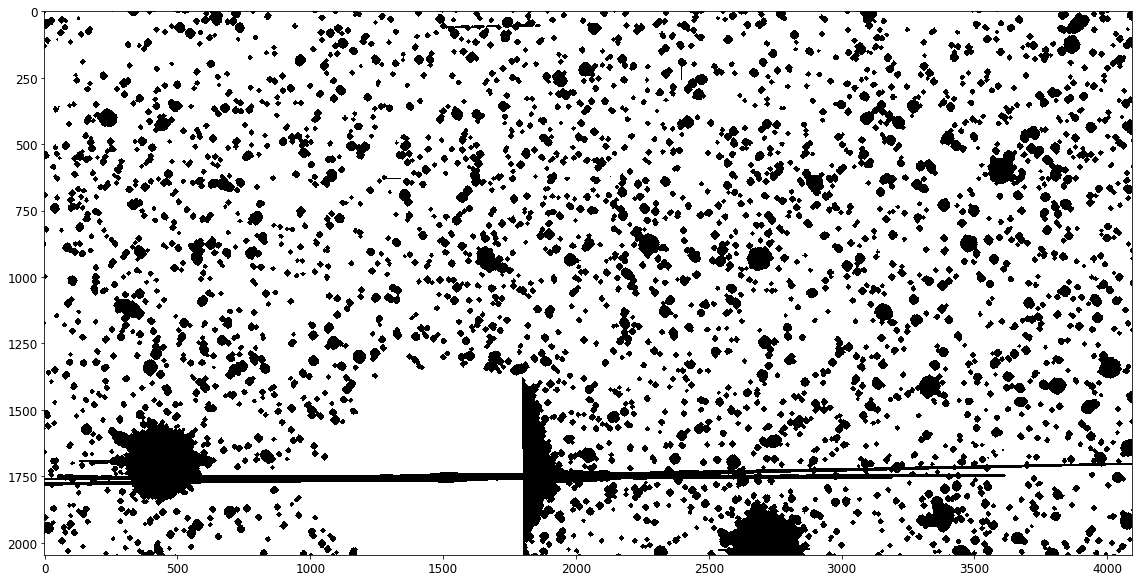

In [56]:
plt.figure(figsize=(20, 10))
plt.imshow(np.flip((img_mask).T, axis=1), cmap='gray')
plt.show()

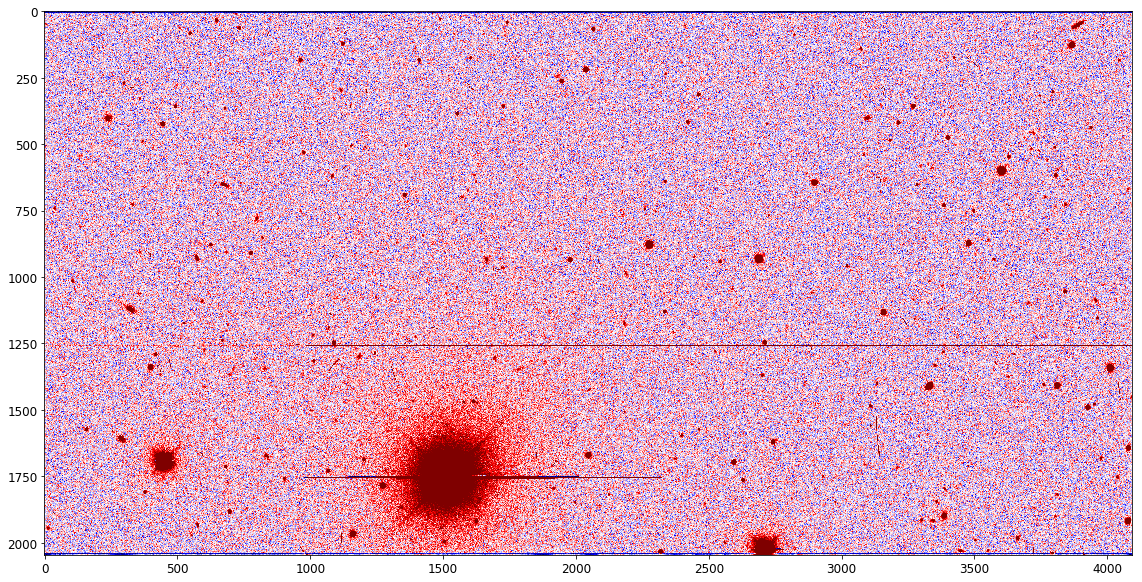

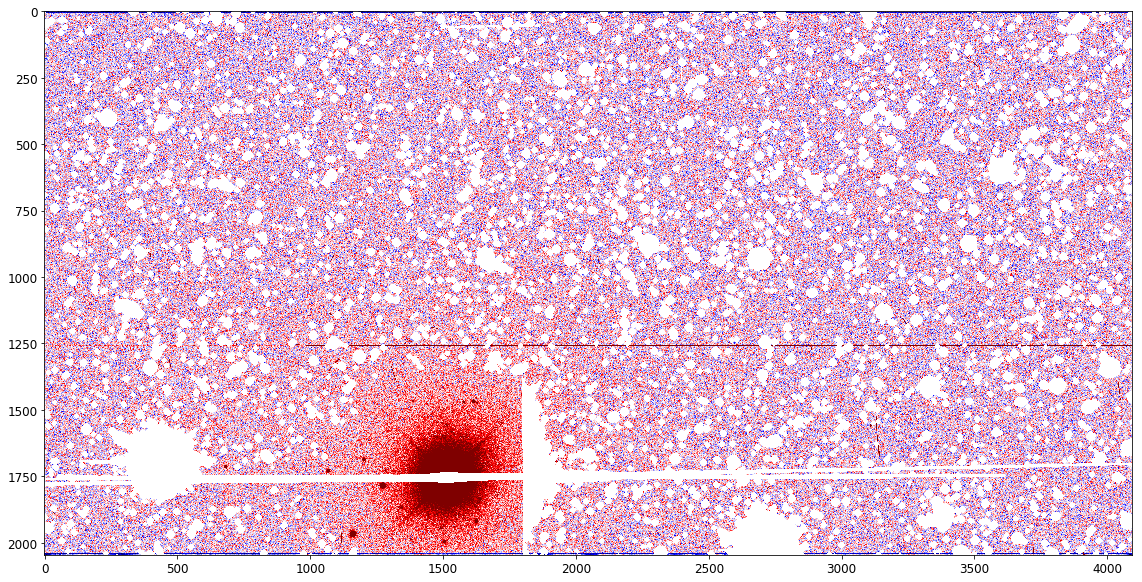

In [59]:
img1 = img.copy()
img1[~img_mask] = np.nan

plt.figure(figsize=(20, 10))
plt.imshow(np.flip((img).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(np.flip((img1).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

In [68]:
def binned_stats(x, y, bins):
    bin_center, bin_median = np.zeros((2, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        if np.sum(mask)>5:
            bin_center[index] = np.median(x[mask])
            bin_median[index] = np.median(y[mask])
        else:
            bin_median[index]
    return bin_center, bin_median

In [89]:
img[img_mask]

array([ 0.00759844,  0.00080985,  0.00408225, ..., -0.01284528,
        0.0249171 , -0.01445792], dtype=float32)

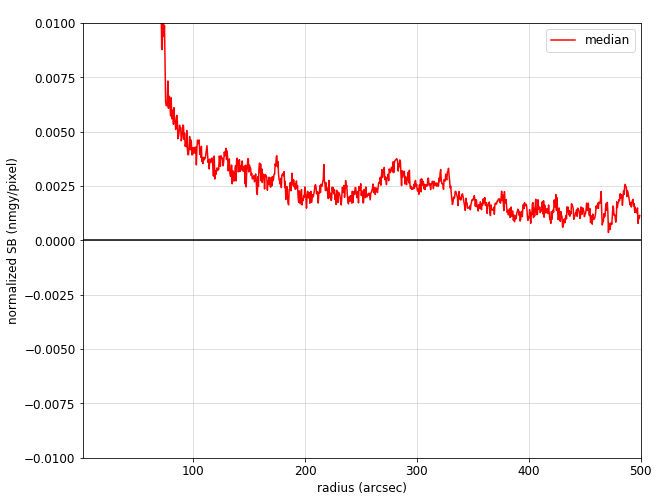

In [93]:
mask = (~img_mask).flatten()
bin_center, bin_median = binned_stats(radius[mask], (img.flatten())[mask], bins=np.arange(1, 500, 0.5))

plt.figure(figsize=(10, 8))
# plt.plot((radius[mask])[::10], ((img+img_predict).flatten()[mask])[::10], '.', ms=0.4, label='image')
# plt.plot(radius_plot, flux_plot, '-', lw=1.5, label='outer PSF')
plt.plot(bin_center, bin_median, '-', lw=1.5, color='r', label='median')
plt.axis([1, 500, -1e-2, 1e-2])
plt.grid(alpha=0.5)
plt.title(' ')
# plt.title('{}-band  decam_{}mag={:.2f}  {}-{}  alpha={:.2f}  beta={:.2f}'.format(band, band, gaia['ls_'+band][gaia_index], expnum_str, ccdname, alpha, beta))
# plt.axhline(norm_factor*sky_nmad, color='r', lw=1.5)
plt.xlabel('radius (arcsec)')
plt.ylabel('normalized SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.axhline(0, color='k', lw=1.5)
plt.show()

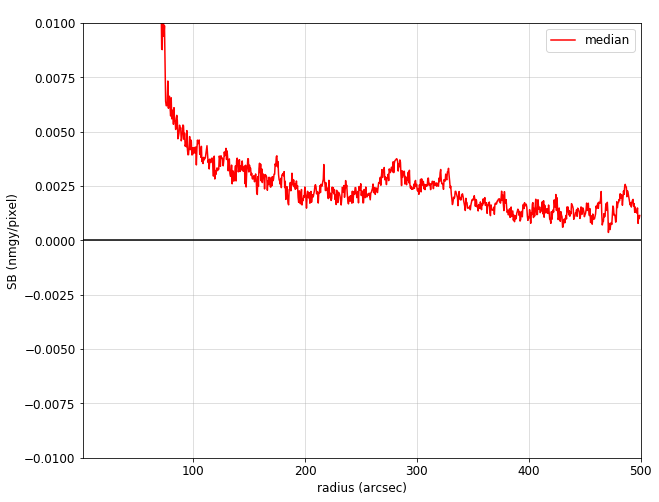

In [94]:
plt.figure(figsize=(10, 8))
plt.plot(bin_center, bin_median, '-', lw=1.5, color='r', label='median')
plt.axis([1, 500, -1e-2, 1e-2])
plt.grid(alpha=0.5)
plt.title(' ')
plt.xlabel('radius (arcsec)')
plt.ylabel('SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.axhline(0, color='k', lw=1.5)
plt.show()

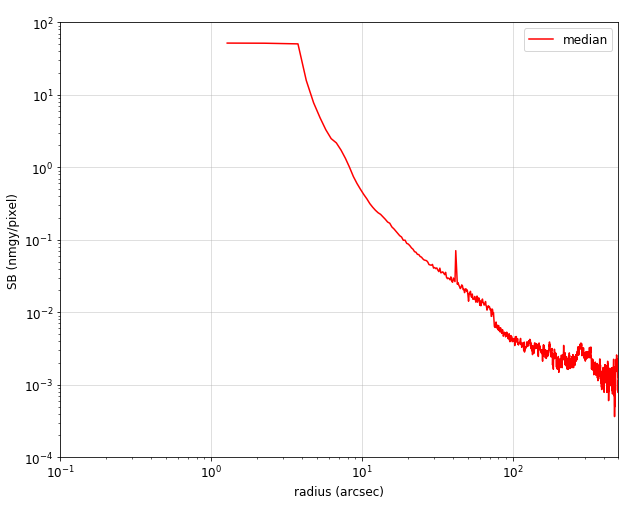

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(bin_center, bin_median, '-', lw=1.5, color='r', label='median')
plt.xscale('log')
plt.yscale('log')
plt.axis([1e-1, 500, 1e-4, 100])
plt.grid(alpha=0.5)
plt.title(' ')
plt.xlabel('radius (arcsec)')
plt.ylabel('SB (nmgy/pixel)')
plt.legend(markerscale=7)
plt.axhline(0, color='k', lw=1.5)
plt.show()